## Tracking pipeline <br>
This notebook demonstrates steps required to bee build trajectories, from bee detections (for those we have [another tutorial](https://github.com/oist/DenseObjectDetection)), through trajectory construction, to generation of videos of tracked bees.

### Requirements
* Python 3.5+
* [TensorFlow](https://www.tensorflow.org/) (1.9 or higher)
* [Numpy](http://www.numpy.org/)
* [Pillow](https://pillow.readthedocs.io/en/stable/)
* [ffmpeg](https://www.ffmpeg.org/)

### Sample data
To start, please download our [sample data](https://beepositions.unit.oist.jp/track_sample_data.zip) and unpack it next to the location of this code folder. The folder structure should be:<br>
```
track_sample_data
+-- checkpoints  
|   +-- model_005000.ckpt.*
+-- detections  
|   +-- *.txt
+-- frames  
|   +-- *.png
```
`frames` folder contains following in time frames from a video of a beehive. `detection` folder contains detections of bees in the respective frames, with text format `x,y,class,angle` for each detection. <br>
We will write data locations to a global variable that we will use throughout this notebook:

In [1]:
import utils
utils.DATA_DIR = "sample_data/" # modify this variable if your data folder is located somewhere else

First we will plot detections to inspect their accuracy. We can plot individual frames: 

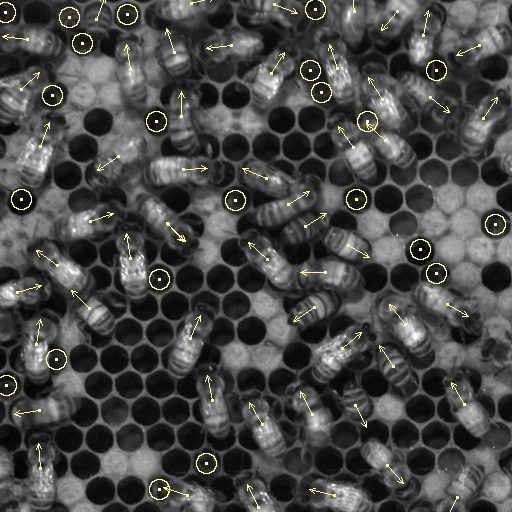

In [2]:
import plot
from IPython.core.display import Image, display
import os

fr = 10
out_path = os.path.join(utils.PLOTS_DIR, "detections")
plot.plot_detections(fr=fr, out_path=out_path)
display(Image(os.path.join(out_path, "%06d.png" % fr), width=256, unconfined=True))

There is 100 frames in this sample dataset, we can build a video of detection images for all of the frames. For this purpose you will need [ffmpeg](https://www.ffmpeg.org/). Modify the location of its executable:

In [3]:
utils.FFMPEG_PATH = "../../ffmpeg/ffmpeg"

Then generate the video:

In [4]:
from IPython.display import Video

plot.plot_detection_video()

display(Video(os.path.join(utils.PLOTS_DIR,"detections.mp4")))

In the trajectory construction procedure we exploit not only position and postural information that is included in the `detections` folder, but also numeric *embeddings* encoding visual aspects of each individual bee. The embeddings are derived from a pretrained neural network.<br>
You can build the embeddings with the `build_embeddings` function in the `embed` module. This function will read the image and detection data, crop the detections from the images and feed into the network. The output of the network is then saved in text and binary files in the `detections_embeddings` subfolder of the data folder.<br>
To run the procedure:

In [5]:
import embed
embed.build_embeddings()

Instructions for updating:
non-resource variables are not supported in the long term
Building the model..
Restoring checkpoint 5000..
Starting infrerence..
...frame: 0
...frame: 8
...frame: 16
...frame: 24
...frame: 32
...frame: 40
...frame: 48
...frame: 56
...frame: 63
...frame: 71
...frame: 78
...frame: 86
...frame: 94
Done..


In the created files the position and posture information `x,y,class,angle` of each detection is concatenated with another 64 numbers forming the embedding of the detection visual features:

In [6]:
import numpy as np

fr = 10
det = np.load(os.path.join(utils.FTS_DIR, "%06d.npy" % fr))
print("frame %i - detections: %i, embedding size: %i" % (fr, det.shape[0], det.shape[1]-4))

frame 10 - detections: 77, embedding size: 64


Using the embeddings we will now perform trajectory construction procedure. The logic and parameters of this procedure are included in the `track` module as described in our manuscript. We will first perform the matching `build_trajectories()`, then sort them according to their length `sort_trajectories`:

In [7]:
import track

track.build_trajectories()
track.sort_trajectories()

frame: 10 finished: 0 continued: 93 saved: 0 discarded: 3
  matched: 73  unmatched: 20   new: 4
  saving trajectory 0, length: 12
  saving trajectory 1, length: 12
frame: 20 finished: 2 continued: 113 saved: 24 discarded: 9
  matched: 72  unmatched: 41   new: 4
  saving trajectory 2, length: 17
  saving trajectory 3, length: 23
frame: 30 finished: 4 continued: 129 saved: 64 discarded: 30
  matched: 74  unmatched: 55   new: 3
  saving trajectory 4, length: 33
frame: 40 finished: 5 continued: 141 saved: 97 discarded: 54
  matched: 70  unmatched: 71   new: 1
  saving trajectory 5, length: 35
  saving trajectory 6, length: 39
  saving trajectory 7, length: 36
  saving trajectory 8, length: 43
  saving trajectory 9, length: 37
frame: 50 finished: 10 continued: 153 saved: 287 discarded: 62
  matched: 74  unmatched: 79   new: 2
frame: 60 finished: 10 continued: 158 saved: 287 discarded: 86
  matched: 79  unmatched: 79   new: 1
  saving trajectory 10, length: 63
frame: 70 finished: 11 continue

Generated trajectories are located in the `trajectories` subfolder of the data folder. In addition to trajectory files, file `tra_lens.txt` lists starting point and length of each trajectory. Using this file can easily inspect the lengths of the generated trajectories:

In [7]:
tra_lens = np.loadtxt(os.path.join(utils.TRACK_DIR, "tra_lens.txt"), delimiter=",", dtype=np.int)

unique, counts = np.unique(tra_lens[:,1], return_counts=True)
dict(zip(unique, counts))

{12: 3,
 17: 1,
 18: 1,
 19: 1,
 22: 2,
 23: 2,
 25: 1,
 27: 1,
 32: 2,
 33: 1,
 35: 1,
 39: 1,
 40: 1,
 43: 2,
 44: 1,
 49: 1,
 50: 2,
 51: 2,
 59: 1,
 62: 2,
 63: 1,
 64: 1,
 67: 1,
 68: 1,
 70: 1,
 71: 1,
 73: 2,
 76: 1,
 77: 2,
 79: 1,
 81: 1,
 82: 2,
 86: 1,
 87: 1,
 88: 2,
 90: 1,
 91: 1,
 94: 3,
 96: 1,
 99: 1,
 100: 49}

Now we can generate videos of some example trajectories. All videos will be stored in the `plots` subfolder of the data folder.

In [8]:
plot.plot_trajectory(28)
plot.plot_trajectory(49)
plot.plot_trajectory(66)

28
49
66


In [9]:
display(Video(os.path.join(utils.PLOTS_DIR,"%06d.mp4" % 28)))

In [10]:
display(Video(os.path.join(utils.PLOTS_DIR,"%06d.mp4" % 49)))

In [11]:
display(Video(os.path.join(utils.PLOTS_DIR,"%06d.mp4" % 66)))

We can also generate a video of all generated trajectories:

In [12]:
plot.plot_all_trajectories()

In [13]:
display(Video(os.path.join(utils.PLOTS_DIR,"all_trajectories.mp4")))